## Objective analysis using Cressman method
**03 August 2023 by MiniUFO**

---
[TOC]

---
### 1. Introduction
It is very common in meteorology that given a number of observations at a set of stations, one needs to interpolate them onto a regular set of grid points.  The well-known method is proposed by [Cressman (1959)](https://journals.ametsoc.org/view/journals/mwre/87/10/1520-0493_1959_087_0367_aooas_2_0_co_2.xml).  Here we implemented this objective-analysis method as a function `oacressmsn` in `utils`, and will demonstrate how to use this.

---
### 2. Demonstration
We have a precipitation dataset, which contains rainfall records at 162 stations.  First load in the dataset.

In [1]:
import numpy as np
import xarray as xr

ds = xr.open_dataset('../ctls/stationPrecip.nc')
precip = ds.precip

print(precip)

<xarray.DataArray 'precip' (stnID: 162, time: 31)>
[5022 values with dtype=float64]
Coordinates:
  * stnID    (stnID) int64 50527 50557 50632 50658 ... 59316 59431 59658 59758
  * time     (time) datetime64[ns] 1951-01-01 1951-01-02 ... 1951-01-31


Now we define a set of lat-lon grid points.  This is also the grid that defines the results of the objective analysis.

In [2]:
lonV = np.linspace(70, 140, 141)
latV = np.linspace(15,  55, 81)

lon = xr.DataArray(lonV, dims='lon', coords={'lon': lonV})
lat = xr.DataArray(latV, dims='lat', coords={'lat': latV})

Perform the objective analysis, using several radii and different weighting methods.

In [5]:
import sys
sys.path.append('../')
from xgrads import oacressman

re1, wei1 = oacressman(precip, ds.lons, ds.lats, 'stnID', lon, lat, rads=[4, 2], method='cressman')
re2, wei2 = oacressman(precip, ds.lons, ds.lats, 'stnID', lon, lat, rads=[4, 2], method='exp')

processing  2.0-deg (4 grids) radius...
processing  1.0-deg (2 grids) radius...
processing  2.0-deg (4 grids) radius...
processing  1.0-deg (2 grids) radius...


Finally, plot the results

/home/qianyk/miniconda3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/qianyk/miniconda3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/qianyk/miniconda3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/qianyk/miniconda3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_pr

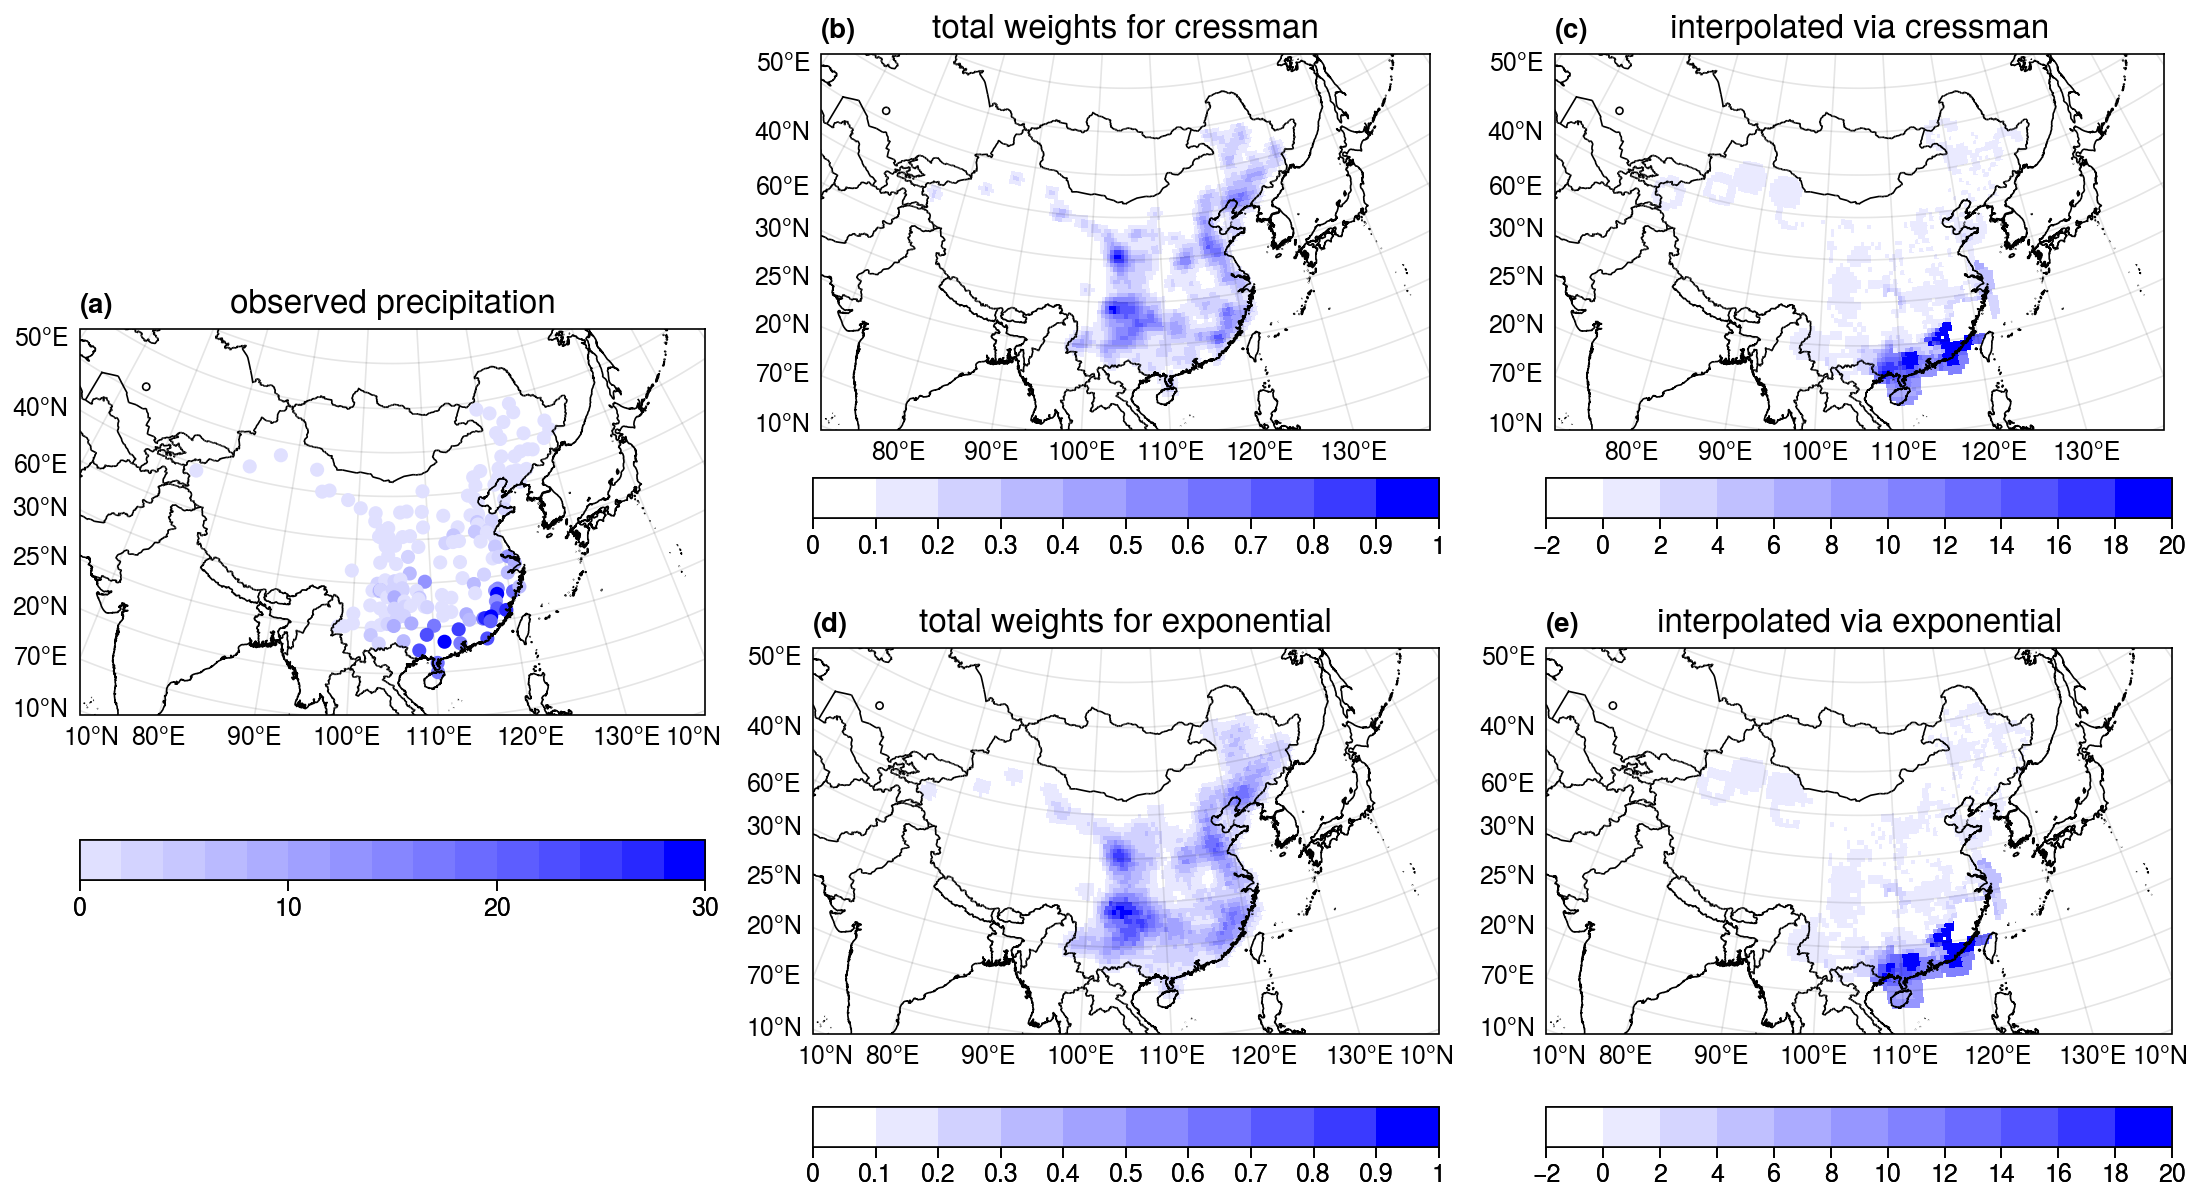

In [6]:
import proplot as pplt

fontsize = 12

arr = [[0, 2, 3],
       [1, 2, 3],
       [1, 4, 5],
       [0, 4, 5]]

fig, axes = pplt.subplots(arr, figsize=(11, 6), proj='lcc', facecolor='w', proj_kw={'central_longitude':105})

ax = axes[0]
m = ax.scatter(ds.lons, ds.lats, c=precip.mean('time'), s=20, zorder=2, cmap='blue', levels=np.linspace(0,30,16))
ax.colorbar(m, loc='b', label='', ticks=10, length=1)
ax.set_title('observed precipitation', fontsize=fontsize)

ax = axes[1]
m = ax.pcolormesh(wei1[0], cmap='blue', levels=np.linspace(0,1, 11))
ax.colorbar(m, loc='b', label='', ticks=0.1, length=1)
ax.set_title('total weights for cressman', fontsize=fontsize)

ax = axes[2]
m = ax.pcolormesh(re1.where(re1!=-9.99e8).where(wei1>0.01).mean('time'), cmap='blue', levels=np.linspace(-2,20, 12))
ax.colorbar(m, loc='b', label='', ticks=2, length=1)
ax.set_title('interpolated via cressman', fontsize=fontsize)

ax = axes[3]
m = ax.pcolormesh(wei2[0], cmap='blue', levels=np.linspace(0,1, 11))
ax.colorbar(m, loc='b', label='', ticks=0.1, length=1)
ax.set_title('total weights for exponential', fontsize=fontsize)

ax = axes[4]
m = ax.pcolormesh(re2.where(re2!=-9.99e8).where(wei2>0.01).mean('time'), cmap='blue', levels=np.linspace(-2,20, 12))
ax.colorbar(m, loc='b', label='', ticks=2, length=1)
ax.set_title('interpolated via exponential', fontsize=fontsize)

axes.format(abc='(a)', borders=True, coast=True, lonlabels=10, latlabels=5, reso='hi', lonlim=[70, 140], latlim=[15, 55])

---

### References:
1. Cressman, G. P., 1959: [An operational objective analysis system](https://journals.ametsoc.org/view/journals/mwre/87/10/1520-0493_1959_087_0367_aooas_2_0_co_2.xml). *Mon. Wea. Rev.*, **87**, 367-374.